# Analisi di un modello per la predizione delle emozioni da un input combinato di testo e immagine

In questo notebook si vuole analizzare il processo della creazione di un modello multimodale per predirre le emozioni. Per l'emotion detection esistono molti modelli che prendono in input un testo o un immagine di un espressione facciale, quindi abbiamo creato il dataset combinando due dataset esistenti. Le istruzioni per costruilo si trovano nella [repository](https://gitlab.com/gabrigeno/emotion-detection-from-image-and-text) del progetto. Una volta creato il dataset, bisogna caricarlo su drive in una cartella chiamata AIExam.

## Data retrival

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp /content/drive/MyDrive/AIExam/data.zip /content
!pip install contractions emoji ekphrasis --quiet
!unzip data.zip

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import LSTM, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt
import pandas as pd
import csv
from PIL import Image
import re
import numpy as np
import contractions, emoji
from ekphrasis.classes.preprocessor import TextPreProcessor
from ekphrasis.classes.tokenizer import SocialTokenizer
from ekphrasis.dicts.emoticons import emoticons

EPOCH = 100

In [ ]:
# Load data
def load_data(file_path):
    data = []
    with open(file_path, newline='', encoding='utf-8') as csvfile:
        csv_reader = csv.reader(csvfile)
        next(csv_reader, None)
        for row in csv_reader:
            text, image_path, emotion = row
            img = Image.open(image_path)
            img_array = np.array(img)
            entry = {'text': text, 'image_data': img_array, 'emotion': emotion}
            data.append(entry)
    return data

file_path = "data/processed/text_image_emotion.csv"
data = load_data(file_path)
print(data[0])

{'text': 'WHY THE FUCK IS BAYLESS ISOING', 'image_data': array([[186,  71, 113, ...,  37,  70, 123],
       [143, 105,  31, ...,  83,  64,  84],
       [152,  91,  69, ...,  89, 103,  50],
       ...,
       [136,  91, 116, ...,  22,  20,  13],
       [227, 112, 109, ...,  19,  16,  12],
       [254, 176, 100, ...,  13,  13,  13]], dtype=uint8), 'emotion': 'anger'}


--- Distribution of Emotion ---
joy         0.282908
neutral     0.243030
anger       0.156648
surprise    0.150884
sadness     0.119907
fear        0.025174
disgust     0.021448
Name: emotion, dtype: float64

Min words in a train sample: 1
Max words in a train sample: 33
Median in a train sample: 13.0


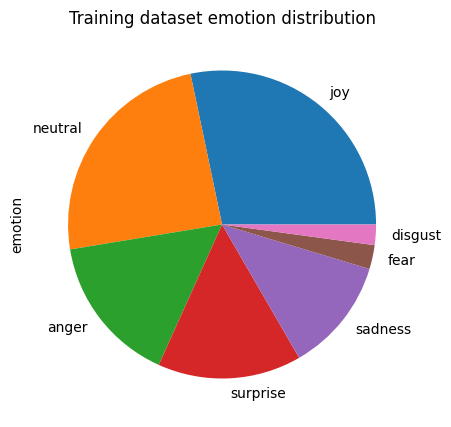

In [ ]:
df_train_raw = pd.read_csv(file_path)

c = df_train_raw.emotion.value_counts(normalize=True)
c.plot(kind="pie", figsize=(5, 5), title="Training dataset emotion distribution")
print("--- Distribution of Emotion ---")
print(c)
train_count = df_train_raw.text.apply(lambda x: len(x.split(" ")))

print(f"\nMin words in a train sample: {train_count.min()}")
print(f"Max words in a train sample: {train_count.max()}")
print(f"Median in a train sample: {train_count.median()}")

Notiamo che il dataset presenta dei testi lunghi al massimo 33 parole con un minimo di una parola.


Dati con indice 123


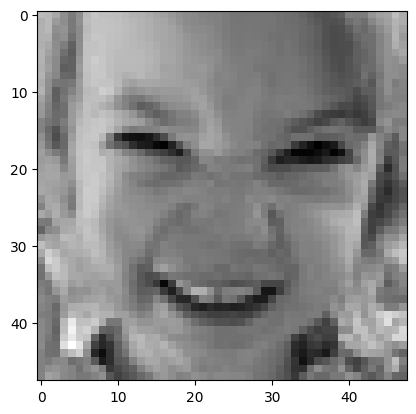

Testo associato: An ex-friend of mine proclaimed than anyone who speaks of being raped is a horrible, unethical human being.
Emozione: anger

Dati con indice 12345


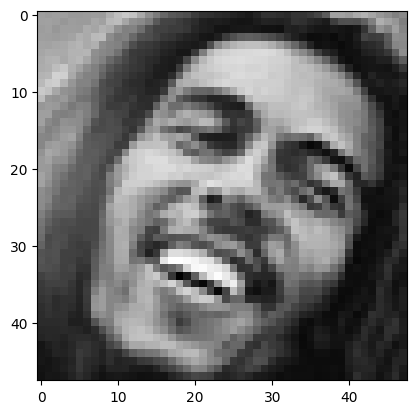

Testo associato: OH MY GOD OH MY GOD CONGRATS!!!!
Emozione: joy


In [ ]:
texts = [entry['text'] for entry in data]
images = np.array([entry['image_data'] for entry in data])
emotions = [entry['emotion'] for entry in data]

def show_data(i):
  print("\nDati con indice", i)
  plt.imshow(images[i],cmap = plt.cm.gray)
  plt.show()
  print("Testo associato:", texts[i])
  print("Emozione:", emotions[i])

show_data(123)

i = 12345
show_data(i)

## Encoding delle emozioni
Traduciamo le emozioni in un vettore di numeri per facilitarne l'uso nella rete neurale.

In [ ]:
label_encoder = LabelEncoder()
encoded_emotions = label_encoder.fit_transform(emotions)
categorical_emotions = tf.keras.utils.to_categorical(encoded_emotions, num_classes=len(label_encoder.classes_))

custom_p = lambda n: print("emotion\t ", n, "  \tis encoded with the number\t", encoded_emotions[emotions.index(n)], "\tand vector\t", categorical_emotions[emotions.index(n)])

custom_p("anger")
custom_p("disgust")
custom_p("fear")
custom_p("joy")
custom_p("neutral")
custom_p("sadness")
custom_p("surprise")

emotion	  anger   	is encoded with the number	 0 	and vector	 [1. 0. 0. 0. 0. 0. 0.]
emotion	  disgust   	is encoded with the number	 1 	and vector	 [0. 1. 0. 0. 0. 0. 0.]
emotion	  fear   	is encoded with the number	 2 	and vector	 [0. 0. 1. 0. 0. 0. 0.]
emotion	  joy   	is encoded with the number	 3 	and vector	 [0. 0. 0. 1. 0. 0. 0.]
emotion	  neutral   	is encoded with the number	 4 	and vector	 [0. 0. 0. 0. 1. 0. 0.]
emotion	  sadness   	is encoded with the number	 5 	and vector	 [0. 0. 0. 0. 0. 1. 0.]
emotion	  surprise   	is encoded with the number	 6 	and vector	 [0. 0. 0. 0. 0. 0. 1.]


## Pre-processing
In questo contesto possiamo applicare del pre-processing sui dati per migliorare il risultato e l'efficenza della rete.

Per il momento usiamo un semplice tokenizer per il testo.

In [ ]:
max_words = 20000
tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer.fit_on_texts(texts)
text_sequences = tokenizer.texts_to_sequences(texts)
text_padded = pad_sequences(text_sequences, padding='post')

## Creazione del dataset
Dividiamo il dataset nella seguente maniera:
*   train data: 80%  
*   validation data: 10%  
*   test data: 10%  

In [ ]:
text_train, text_test_temp, image_train, image_test_temp, emotion_train, emotion_test_temp = train_test_split(
    text_padded, images, categorical_emotions, test_size=0.2, random_state=42
)

text_test, text_val, image_test, image_val, emotion_test, emotion_val = train_test_split(
    text_test_temp, image_test_temp, emotion_test_temp, test_size=0.5, random_state=42
)

print("Lunghezza dati di train:", len(text_train))
print("Lunghezza dati di validation:", len(text_val))
print("Lunghezza dati di test:", len(text_test))

Lunghezza dati di train: 20402
Lunghezza dati di validation: 2551
Lunghezza dati di test: 2550


## Creazione del primo semplice modello

Le emozioni prese in considerazioni sono 7, quindi un modello completamente randomico ha una precisione del 14%.

Puntiamo quindi a fare meglio di un modello randomico creando un semplice modello con dei layer densi per ogni tipo di input e per poi concatenarli.

In [ ]:
# prima parte
text_input = layers.Input(shape=text_padded.shape[1], dtype=tf.int32)
text_dense_layer = layers.Dense(64, activation='relu')(text_input)

# seconda parte
image_input = layers.Input(shape=(48, 48))
image_dense_layer = layers.Dense(64, activation='relu')(image_input)
image_flatten = layers.Flatten()(image_dense_layer)

concatenated = layers.Concatenate()([text_dense_layer, image_flatten])
dropout_layer = layers.Dropout(0.5)(concatenated)
dense_layer = layers.Dense(64, activation='relu')(image_input)
output_layer = layers.Dense(len(label_encoder.classes_), activation='softmax')(dropout_layer)

model = models.Model(inputs=[text_input, image_input], outputs=output_layer)

optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

checkpoint_callback = ModelCheckpoint("best_model.h5", save_best_only=True, monitor="val_accuracy", mode="max")

early_stopping_callback = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 48, 48)]             0         []                            
                                                                                                  
 input_7 (InputLayer)        [(None, 84)]                 0         []                            
                                                                                                  
 dense_7 (Dense)             (None, 48, 64)               3136      ['input_8[0][0]']             
                                                                                                  
 dense_6 (Dense)             (None, 64)                   5440      ['input_7[0][0]']             
                                                                                            

In [ ]:
model.fit([text_train, image_train], emotion_train, epochs=EPOCH, validation_data=([text_val, image_val], emotion_val), callbacks=[checkpoint_callback, early_stopping_callback])

evaluation_results = model.evaluate([text_test, image_test], emotion_test)
print(f"Loss: {round(evaluation_results[0], 2)}, Accuracy: {round(evaluation_results[1], 2)}")

Epoch 1/100
638/638 [==============================] - 5s 6ms/step - loss: 221.8052 - accuracy: 0.2174 - val_loss: 59.1412 - val_accuracy: 0.2881
Epoch 2/100
638/638 [==============================] - 3s 4ms/step - loss: 75.4312 - accuracy: 0.2329 - val_loss: 21.8433 - val_accuracy: 0.2971
Epoch 3/100
638/638 [==============================] - 3s 4ms/step - loss: 20.2702 - accuracy: 0.2368 - val_loss: 8.0141 - val_accuracy: 0.2826
Epoch 4/100
638/638 [==============================] - 3s 4ms/step - loss: 8.1963 - accuracy: 0.2265 - val_loss: 4.7101 - val_accuracy: 0.1972
Epoch 5/100
638/638 [==============================] - 3s 5ms/step - loss: 4.7674 - accuracy: 0.2186 - val_loss: 3.2167 - val_accuracy: 0.2623
Epoch 6/100
638/638 [==============================] - 3s 4ms/step - loss: 3.8707 - accuracy: 0.2241 - val_loss: 2.8717 - val_accuracy: 0.2630
Epoch 7/100
638/638 [==============================] - 3s 4ms/step - loss: 3.5456 - accuracy: 0.2228 - val_loss: 2.7674 - val_accuracy: 

Tramite questo semplice modello con 27335 parametri si raggiunge una precisione circa del 30%  (loss: 1.86) andando quindi a migliorare la precisione di circa 2.4 volte rispetto a un modello casuale.

## Seconda prova
In questo seconda prova andiamo a cambiare solo le immagini normalizzandole per andare a vedere come influisce sulla rete.

In [ ]:
print("Image", images[i])
norm_images = images / 255
print("\nNormalized image", norm_images[i])

# ricreaiamo il dataset
text_train, text_test_temp, image_train, image_test_temp, emotion_train, emotion_test_temp = train_test_split(
    text_padded, norm_images, categorical_emotions, test_size=0.2, random_state=42
)

text_test, text_val, image_test, image_val, emotion_test, emotion_val = train_test_split(
    text_test_temp, image_test_temp, emotion_test_temp, test_size=0.5, random_state=42
)

Image [[159 156 159 ... 142 129 137]
 [160 161 158 ... 162 150 127]
 [157 160 151 ... 132 159 133]
 ...
 [ 23  20  25 ...  19  36  37]
 [ 19  21  25 ...  23  39  27]
 [ 17  23  22 ...  28  44  24]]

Normalized image [[0.62352941 0.61176471 0.62352941 ... 0.55686275 0.50588235 0.5372549 ]
 [0.62745098 0.63137255 0.61960784 ... 0.63529412 0.58823529 0.49803922]
 [0.61568627 0.62745098 0.59215686 ... 0.51764706 0.62352941 0.52156863]
 ...
 [0.09019608 0.07843137 0.09803922 ... 0.0745098  0.14117647 0.14509804]
 [0.0745098  0.08235294 0.09803922 ... 0.09019608 0.15294118 0.10588235]
 [0.06666667 0.09019608 0.08627451 ... 0.10980392 0.17254902 0.09411765]]


In [ ]:
model.fit([text_train, image_train], emotion_train, epochs=EPOCH, validation_data=([text_val, image_val], emotion_val), callbacks=[checkpoint_callback, early_stopping_callback])

evaluation_results = model.evaluate([text_test, image_test], emotion_test)
print(f"Loss: {round(evaluation_results[0], 2)}, Accuracy: {round(evaluation_results[1], 2)}")

Epoch 1/100
638/638 [==============================] - 4s 5ms/step - loss: 1.8916 - accuracy: 0.2662 - val_loss: 1.8039 - val_accuracy: 0.2525
Epoch 2/100
638/638 [==============================] - 3s 5ms/step - loss: 1.8208 - accuracy: 0.2710 - val_loss: 1.7768 - val_accuracy: 0.2709
Epoch 3/100
638/638 [==============================] - 3s 4ms/step - loss: 1.7962 - accuracy: 0.2741 - val_loss: 1.7614 - val_accuracy: 0.2705
Epoch 4/100
638/638 [==============================] - 3s 4ms/step - loss: 1.7592 - accuracy: 0.2790 - val_loss: 1.7491 - val_accuracy: 0.2850
Epoch 5/100
638/638 [==============================] - 5s 8ms/step - loss: 1.7322 - accuracy: 0.2892 - val_loss: 1.7201 - val_accuracy: 0.2834
Epoch 6/100
638/638 [==============================] - 5s 7ms/step - loss: 1.7113 - accuracy: 0.2990 - val_loss: 1.7011 - val_accuracy: 0.2936
Epoch 7/100
638/638 [==============================] - 3s 4ms/step - loss: 1.7030 - accuracy: 0.3122 - val_loss: 1.6783 - val_accuracy: 0.3218

Applicando una semplice operazione di normalizzazione raggiungiamo con lo stesso modello una precisione del 45% (loss: 1.48) migliorando di 3.2 volte rispetto a un modello casuale.

## Terza prova

In questa prova andiamo ad aggiungere dei layer più complicati per i due input per migliorare ulteriormente la precisione. Scegliamo un layer Embedding per il testo e dei layer convoluzionali per le immagini.

In [ ]:
text_input = layers.Input(shape=text_padded.shape[1], dtype=tf.int32)
embedding_layer = layers.Embedding(input_dim=max_words, output_dim=8, input_length=text_padded.shape[1])(text_input)
text_flatten = layers.Flatten()(embedding_layer)

image_input = layers.Input(shape=(48, 48, 1))
conv_layer = layers.Conv2D(32, (3, 3), activation='relu')(image_input)
pooling_layer = layers.MaxPooling2D((2, 2))(conv_layer)
image_flatten = layers.Flatten()(pooling_layer)

concatenated = layers.Concatenate()([text_flatten, image_flatten])
dropout_layer = layers.Dropout(0.5)(concatenated)
output_layer = layers.Dense(len(label_encoder.classes_), activation='softmax')(dropout_layer)

model = models.Model(inputs=[text_input, image_input], outputs=output_layer)
optimizer = Adam(learning_rate=0.0001)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 48, 48, 1)]          0         []                            
                                                                                                  
 input_5 (InputLayer)        [(None, 34)]                 0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 46, 46, 32)           320       ['input_6[0][0]']             
                                                                                                  
 embedding (Embedding)       (None, 34, 8)                160000    ['input_5[0][0]']             
                                                                                            

In [ ]:
model.fit([text_train, image_train], emotion_train, epochs=EPOCH, validation_data=([text_val, image_val], emotion_val), callbacks=[checkpoint_callback, early_stopping_callback])

evaluation_results = model.evaluate([text_test, image_test], emotion_test)
print(f"Loss: {round(evaluation_results[0], 2)}, Accuracy: {round(evaluation_results[1], 2)}")

Epoch 1/100
585/585 [==============================] - 33s 55ms/step - loss: 1.6812 - accuracy: 0.3140 - val_loss: 1.6213 - val_accuracy: 0.3657
Epoch 2/100
585/585 [==============================] - 29s 50ms/step - loss: 1.5862 - accuracy: 0.3767 - val_loss: 1.5645 - val_accuracy: 0.3981
Epoch 3/100
585/585 [==============================] - 27s 46ms/step - loss: 1.5336 - accuracy: 0.4174 - val_loss: 1.5105 - val_accuracy: 0.4310
Epoch 4/100
585/585 [==============================] - 26s 45ms/step - loss: 1.4902 - accuracy: 0.4403 - val_loss: 1.4812 - val_accuracy: 0.4353
Epoch 5/100
585/585 [==============================] - 27s 46ms/step - loss: 1.4567 - accuracy: 0.4588 - val_loss: 1.4483 - val_accuracy: 0.4699
Epoch 6/100
585/585 [==============================] - 27s 46ms/step - loss: 1.4204 - accuracy: 0.4823 - val_loss: 1.4277 - val_accuracy: 0.4891
Epoch 7/100
585/585 [==============================] - 27s 46ms/step - loss: 1.3930 - accuracy: 0.4925 - val_loss: 1.4003 - val_ac

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


585/585 [==============================] - 26s 45ms/step - loss: 1.1643 - accuracy: 0.5931 - val_loss: 1.2275 - val_accuracy: 0.5609
Epoch 18/100
585/585 [==============================] - 27s 46ms/step - loss: 1.1485 - accuracy: 0.5951 - val_loss: 1.2203 - val_accuracy: 0.5609
Epoch 19/100
585/585 [==============================] - 27s 47ms/step - loss: 1.1283 - accuracy: 0.6048 - val_loss: 1.2138 - val_accuracy: 0.5664
Epoch 20/100
585/585 [==============================] - 27s 47ms/step - loss: 1.1156 - accuracy: 0.6100 - val_loss: 1.2011 - val_accuracy: 0.5737
Epoch 21/100
585/585 [==============================] - 27s 47ms/step - loss: 1.0989 - accuracy: 0.6203 - val_loss: 1.1886 - val_accuracy: 0.5780
Epoch 22/100
585/585 [==============================] - 27s 47ms/step - loss: 1.0842 - accuracy: 0.6255 - val_loss: 1.1809 - val_accuracy: 0.5852
Epoch 23/100
585/585 [==============================] - 29s 50ms/step - loss: 1.0683 - accuracy: 0.6288 - val_loss: 1.1662 - val_accuracy

Aggiungendo dei layer che vanno ad operare su i due input abbiamo un aumento di circa 9.2 volte dei parametri arrivando a una precisione del 63% circa (loss: 0.98) che corrisponde a circa 4.6 volte migliore del modello randomico.

## Quarta prova
Riduciamo il dataset, togliendo le scritte troppo piccole o troppo grandi. Abbassiamo il numero di filtri convoluzionali. Controlliamo anche che la distribuzione non sia cambiata di troppo.

Numero di dati = 20335
Numero di dati = 16271

--- Distribution of Emotion ---
joy         0.278287
neutral     0.235450
surprise    0.159609
anger       0.155922
sadness     0.123164
fear        0.024891
disgust     0.022678
dtype: float64


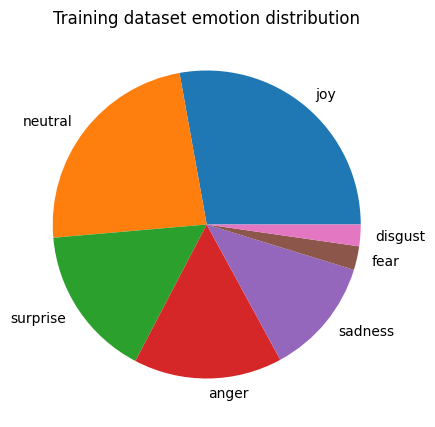

In [ ]:
data = list(filter(lambda x: len(x["text"].split(" ")) < 20, data))
print("Numero di dati =", len(data))
data = list(filter(lambda x: len(x["text"].split(" ")) > 5, data))
print("Numero di dati =", len(data))
texts = [entry['text'] for entry in data]
images = np.array([entry['image_data'] for entry in data])
norm_images = images / 255
emotions = [entry['emotion'] for entry in data]
c = pd.Series(emotions).value_counts(normalize=True)
c.plot(kind="pie", figsize=(5, 5), title="Training dataset emotion distribution")
print("\n--- Distribution of Emotion ---")
print(c)

max_words = 20000
tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer.fit_on_texts(texts)
text_sequences = tokenizer.texts_to_sequences(texts)
text_padded = pad_sequences(text_sequences, padding='post')
label_encoder = LabelEncoder()
encoded_emotions = label_encoder.fit_transform(emotions)
categorical_emotions = tf.keras.utils.to_categorical(encoded_emotions, num_classes=len(label_encoder.classes_))

text_train, text_test_temp, image_train, image_test_temp, emotion_train, emotion_test_temp = train_test_split(
    text_padded, norm_images, categorical_emotions, test_size=0.2, random_state=42
)

text_test, text_val, image_test, image_val, emotion_test, emotion_val = train_test_split(
    text_test_temp, image_test_temp, emotion_test_temp, test_size=0.5, random_state=42
)

In [ ]:
text_input = layers.Input(shape=(text_padded.shape[1],), dtype=tf.int32)
embedding_layer = layers.Embedding(input_dim=max_words, output_dim=8, input_length=text_padded.shape[1])(text_input)
text_flatten = layers.Flatten()(embedding_layer)

image_input = layers.Input(shape=(48, 48, 1))
conv_layer = layers.Conv2D(24, (3, 3), activation='relu')(image_input)
pooling_layer = layers.MaxPooling2D((2, 2))(conv_layer)
image_flatten = layers.Flatten()(pooling_layer)

concatenated = layers.Concatenate()([text_flatten, image_flatten])
dropout_layer = layers.Dropout(0.5)(concatenated)
output_layer = layers.Dense(len(label_encoder.classes_), activation='softmax')(dropout_layer)

optimizer = Adam(learning_rate=0.0001)
model = models.Model(inputs=[text_input, image_input], outputs=output_layer)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_24 (InputLayer)       [(None, 48, 48, 1)]          0         []                            
                                                                                                  
 input_23 (InputLayer)       [(None, 24)]                 0         []                            
                                                                                                  
 conv2d_3 (Conv2D)           (None, 46, 46, 24)           240       ['input_24[0][0]']            
                                                                                                  
 embedding_3 (Embedding)     (None, 24, 8)                160000    ['input_23[0][0]']            
                                                                                           

In [ ]:
model.fit([text_train, image_train], emotion_train, epochs=EPOCH, validation_data=([text_val, image_val], emotion_val), callbacks=[checkpoint_callback, early_stopping_callback])

evaluation_results = model.evaluate([text_test, image_test], emotion_test)
print(f"Loss: {round(evaluation_results[0], 2)}, Accuracy: {round(evaluation_results[1], 2)}")

Epoch 1/100
372/372 [==============================] - 15s 38ms/step - loss: 1.7192 - accuracy: 0.2975 - val_loss: 1.6695 - val_accuracy: 0.2995
Epoch 2/100
372/372 [==============================] - 14s 37ms/step - loss: 1.6350 - accuracy: 0.3397 - val_loss: 1.5994 - val_accuracy: 0.3915
Epoch 3/100
372/372 [==============================] - 14s 38ms/step - loss: 1.5845 - accuracy: 0.3827 - val_loss: 1.5655 - val_accuracy: 0.3828
Epoch 4/100
372/372 [==============================] - 14s 38ms/step - loss: 1.5505 - accuracy: 0.4028 - val_loss: 1.5367 - val_accuracy: 0.4318
Epoch 5/100
372/372 [==============================] - 14s 38ms/step - loss: 1.5224 - accuracy: 0.4249 - val_loss: 1.5156 - val_accuracy: 0.4560
Epoch 6/100
372/372 [==============================] - 14s 38ms/step - loss: 1.4946 - accuracy: 0.4417 - val_loss: 1.4945 - val_accuracy: 0.4527
Epoch 7/100
372/372 [==============================] - 14s 38ms/step - loss: 1.4725 - accuracy: 0.4536 - val_loss: 1.4700 - val_ac

loss 1.04 e accuracy 64%

## Quinta prova
In questo test, cerchiamo di migliorare il preprocessing del testo.

In [ ]:
def lowerize(data):
  return list(map(lambda x: x.lower(), data))

def remove_special_chars(data):
  return list(map(lambda x: x.replace('|'.join([re.escape(c) for c in list("#%&*/:\^_{|}~")]), ""), data))

def convert_emojis(data):
  return list(map(lambda x: emoji.demojize(x), data))

def split_contractions(data):
  return list(map(lambda x: contractions.fix(x), data))

text_processor = TextPreProcessor(normalize= ['money', 'user', 'time', 'date', 'number', 'phone'],
                                  annotate={"elongated", "repeated", 'emphasis', 'censored'},
                                  fix_html=True, tokenizer=SocialTokenizer(lowercase=True).tokenize,
                                  segmenter="twitter", corrector="twitter", unpack_contractions=False,
                                  spell_correct_elong=True, spell_correction=True, fix_text=True,
                                  dicts=[emoticons])

def df_preprocessing(df_pre):
  df_pre = lowerize(df_pre)
  df_pre = convert_emojis(df_pre)
  df_pre = split_contractions(df_pre)
  df_pre = list(map(lambda x: ' '.join(text_processor.pre_process_doc(x)).strip(), df_pre))
  df_pre = remove_special_chars(df_pre)
  return df_pre

In [ ]:
texts = [entry['text'] for entry in data]
images = np.array([entry['image_data'] for entry in data])
norm_images = images / 255
emotions = [entry['emotion'] for entry in data]

texts = df_preprocessing(texts)

max_words = 20000
tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer.fit_on_texts(texts)
text_sequences = tokenizer.texts_to_sequences(texts)
text_padded = pad_sequences(text_sequences, padding='post')
label_encoder = LabelEncoder()
encoded_emotions = label_encoder.fit_transform(emotions)
categorical_emotions = tf.keras.utils.to_categorical(encoded_emotions, num_classes=len(label_encoder.classes_))

text_train, text_test_temp, image_train, image_test_temp, emotion_train, emotion_test_temp = train_test_split(
    text_padded, norm_images, categorical_emotions, test_size=0.2, random_state=42
)

text_test, text_val, image_test, image_val, emotion_test, emotion_val = train_test_split(
    text_test_temp, image_test_temp, emotion_test_temp, test_size=0.2, random_state=42
)

In [ ]:
text_input = layers.Input(shape=text_padded.shape[1], dtype=tf.int32)
embedding_layer = layers.Embedding(input_dim=max_words, output_dim=8, input_length=text_padded.shape[1])(text_input)
text_flatten = layers.Flatten()(embedding_layer)

image_input = layers.Input(shape=(48, 48, 1))
conv_layer = layers.Conv2D(24, (3, 3), activation='relu')(image_input)
pooling_layer = layers.MaxPooling2D((2, 2))(conv_layer)
image_flatten = layers.Flatten()(pooling_layer)

concatenated = layers.Concatenate()([text_flatten, image_flatten])
dropout_layer = layers.Dropout(0.5)(concatenated)
output_layer = layers.Dense(len(label_encoder.classes_), activation='softmax')(dropout_layer)

optimizer = Adam(learning_rate=0.0001)
model = models.Model(inputs=[text_input, image_input], outputs=output_layer)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 48, 48, 1)]          0         []                            
                                                                                                  
 input_7 (InputLayer)        [(None, 84)]                 0         []                            
                                                                                                  
 conv2d_1 (Conv2D)           (None, 46, 46, 24)           240       ['input_8[0][0]']             
                                                                                                  
 embedding_1 (Embedding)     (None, 84, 8)                160000    ['input_7[0][0]']             
                                                                                            

In [ ]:
model.fit([text_train, image_train], emotion_train, epochs=EPOCH, validation_data=([text_val, image_val], emotion_val), callbacks=[checkpoint_callback, early_stopping_callback])

evaluation_results = model.evaluate([text_test, image_test], emotion_test)
print(f"Loss: {round(evaluation_results[0], 2)}, Accuracy: {round(evaluation_results[1], 2)}")

Epoch 1/100
638/638 [==============================] - 22s 29ms/step - loss: 1.6862 - accuracy: 0.3094 - val_loss: 1.6211 - val_accuracy: 0.3634
Epoch 2/100
638/638 [==============================] - 4s 6ms/step - loss: 1.5878 - accuracy: 0.3888 - val_loss: 1.5590 - val_accuracy: 0.4221
Epoch 3/100
638/638 [==============================] - 5s 7ms/step - loss: 1.5313 - accuracy: 0.4246 - val_loss: 1.5126 - val_accuracy: 0.4584
Epoch 4/100
638/638 [==============================] - 4s 6ms/step - loss: 1.4889 - accuracy: 0.4496 - val_loss: 1.4819 - val_accuracy: 0.4691
Epoch 5/100
 17/638 [..............................] - ETA: 3s - loss: 1.4888 - accuracy: 0.4430

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


638/638 [==============================] - 6s 10ms/step - loss: 1.4536 - accuracy: 0.4669 - val_loss: 1.4543 - val_accuracy: 0.4838
Epoch 6/100
638/638 [==============================] - 6s 9ms/step - loss: 1.4237 - accuracy: 0.4816 - val_loss: 1.4210 - val_accuracy: 0.4927
Epoch 7/100
638/638 [==============================] - 4s 6ms/step - loss: 1.3912 - accuracy: 0.4955 - val_loss: 1.4001 - val_accuracy: 0.4946
Epoch 8/100
638/638 [==============================] - 6s 10ms/step - loss: 1.3641 - accuracy: 0.5042 - val_loss: 1.3798 - val_accuracy: 0.5122
Epoch 9/100
638/638 [==============================] - 3s 5ms/step - loss: 1.3379 - accuracy: 0.5202 - val_loss: 1.3522 - val_accuracy: 0.5191
Epoch 10/100
638/638 [==============================] - 3s 5ms/step - loss: 1.3143 - accuracy: 0.5280 - val_loss: 1.3341 - val_accuracy: 0.5348
Epoch 11/100
638/638 [==============================] - 3s 4ms/step - loss: 1.2902 - accuracy: 0.5387 - val_loss: 1.3165 - val_accuracy: 0.5387
Epoch 1

Il modello non subisce notevoli cambiamenti, infatti l'accuracy rimane pressoché la stessa.

## Sesta prova

In questa prova proviamo a migliorare la precisione andando ad aggiungere dei layer Convoluzionalie un layer di normalizzazione.

In [ ]:
text_input = layers.Input(shape=text_padded.shape[1], dtype=tf.int32)
embedding_layer = layers.Embedding(input_dim=max_words, output_dim=8, input_length=text_padded.shape[1])(text_input)
text_flatten = layers.Flatten()(embedding_layer)
nl = layers.Normalization()(text_flatten)

image_input = layers.Input(shape=(48, 48, 1))
conv_layer = layers.Conv2D(32, (3, 3), activation='relu')(image_input)
pooling_layer1 = layers.MaxPooling2D((2, 2))(conv_layer)
conv_layer2 = layers.Conv2D(24, (3, 3), activation='relu')(pooling_layer1)
pooling_layer2 = layers.MaxPooling2D((2, 2))(conv_layer2)
image_flatten = layers.Flatten()(pooling_layer2)

concatenated = layers.Concatenate()([image_flatten, nl])
dropout_layer = layers.Dropout(0.5)(concatenated)
output_layer = layers.Dense(len(label_encoder.classes_), activation='softmax')(dropout_layer)

optimizer = Adam(learning_rate=0.0001)
model = models.Model(inputs=[text_input, image_input], outputs=output_layer)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 48, 48, 1)]          0         []                            
                                                                                                  
 conv2d_2 (Conv2D)           (None, 46, 46, 32)           320       ['input_6[0][0]']             
                                                                                                  
 max_pooling2d_2 (MaxPoolin  (None, 23, 23, 32)           0         ['conv2d_2[0][0]']            
 g2D)                                                                                             
                                                                                                  
 input_5 (InputLayer)        [(None, 84)]                 0         []                      

In [ ]:
model.fit([text_train, image_train], emotion_train, epochs=EPOCH, validation_data=([text_val, image_val], emotion_val), callbacks=[checkpoint_callback, early_stopping_callback])

evaluation_results = model.evaluate([text_test, image_test], emotion_test)
print(f"Loss: {round(evaluation_results[0], 2)}, Accuracy: {round(evaluation_results[1], 2)}")

Epoch 1/100
585/585 [==============================] - 22s 37ms/step - loss: 1.7124 - accuracy: 0.3011 - val_loss: 1.6489 - val_accuracy: 0.3095
Epoch 2/100
585/585 [==============================] - 23s 40ms/step - loss: 1.6221 - accuracy: 0.3467 - val_loss: 1.5842 - val_accuracy: 0.3714
Epoch 3/100
585/585 [==============================] - 22s 38ms/step - loss: 1.5618 - accuracy: 0.3916 - val_loss: 1.5296 - val_accuracy: 0.4184
Epoch 4/100
585/585 [==============================] - 21s 37ms/step - loss: 1.5230 - accuracy: 0.4123 - val_loss: 1.4995 - val_accuracy: 0.4536
Epoch 5/100
585/585 [==============================] - 21s 37ms/step - loss: 1.4929 - accuracy: 0.4353 - val_loss: 1.4710 - val_accuracy: 0.4653
Epoch 6/100
585/585 [==============================] - 21s 35ms/step - loss: 1.4634 - accuracy: 0.4491 - val_loss: 1.4483 - val_accuracy: 0.4792
Epoch 7/100
585/585 [==============================] - 21s 36ms/step - loss: 1.4325 - accuracy: 0.4679 - val_loss: 1.4231 - val_ac

L'accuracy sale al 68% a fronte però di una diminuzione dei parametri ma di un allungamento dei tempi.